# Let's try testing out the 'standard' routine for setting up an image Neural Net following lesson 3 from the fastai DL1 course.

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.imports import *
from fastai.torch_imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [3]:
torch.cuda.set_device(0)

In [4]:
PATH = "data/humpback-whale/"
sz = 224
arch = resnext101_64
bs = 58

NOTE: Here we're taking a random 20% of the data for the validation set. This is different from when we looked at structured data. Is this sample a 'good' validation set, i.e. is it a good representation of the test set? Also, is this too much/too little?

In [5]:
label_csv = f'{PATH}train.csv'
n = len(list(open(label_csv))) - 1 # header is not counted (-1)
val_idxs = get_cv_idxs(n) # random 20% data for validation set

In [6]:
n

25361

In [7]:
label_df = pd.read_csv(label_csv)
label_df.head()

,Image,Id
0,0000e88ab.jpg,w_f48451c
1,0001f9222.jpg,w_c3d896a
2,00029d126.jpg,w_20df2c5
3,00050a15a.jpg,new_whale
4,0005c1ef8.jpg,new_whale


In [10]:
label_df.pivot_table(index="Id", aggfunc=len).sort_values('Image', ascending=False)

,Image
Id,
new_whale,9664
w_23a388d,73
w_9b5109b,65
w_9c506f6,62
w_0369a5c,61
w_700ebb4,57
w_3de579a,54
w_564a34b,51
w_fd3e556,50


Apparently there is a 'new whale' distinction. In order to have a proper validation set, we'll want a similar fraction of new whales as is in the test set. Also it appears as though a significant portion of these whales have **very** few examples. Looking at the distribution of images [kernal on kaggle](https://www.kaggle.com/kretes/eda-distributions-images-and-no-duplicates) we see that almost 30% have 4 images or less while 30% have between 5-73 images.

Let's now enhance our data set with some data augmentation. 

In [13]:
tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=1.1)
data = ImageClassifierData.from_csv(PATH, 'train', f'{PATH}train.csv', test_name='test', # we need to specify where the test set is if you want to submit to Kaggle competitions
                                   val_idxs=val_idxs, suffix='', tfms=tfms, bs=bs)

In [25]:
fn = PATH + data.trn_ds.fnames[1]; fn

'data/humpback-whale/train/0001f9222.jpg'

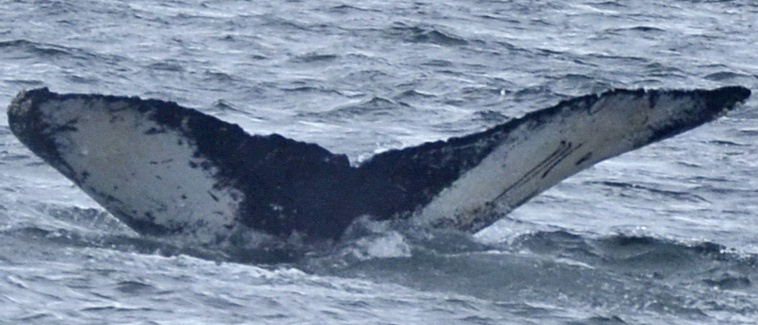

In [26]:
img = PIL.Image.open(fn); img

In [16]:
img.size

(1050, 700)

This is a large img. Let's check the dataset to see the typical img size.

In [18]:
size_d = {k:PIL.Image.open(PATH + k).size for k in data.trn_ds.fnames}

In [19]:
row_sz, col_sz = list(zip(*size_d.values()))

In [20]:
row_sz = np.array(row_sz); col_sz = np.array(col_sz)

(array([ 1276., 18677.,   181.,    49.,    59.,    18.,     9.,     4.,     2.,    14.]),
 array([  77. ,  665.2, 1253.4, 1841.6, 2429.8, 3018. , 3606.2, 4194.4, 4782.6, 5370.8, 5959. ]),
 <a list of 10 Patch objects>)

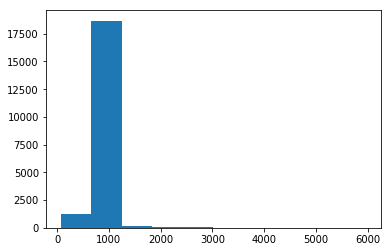

In [21]:
plt.hist(row_sz)

(array([   51.,   279.,   889.,  2197.,  2330., 14203.,    47.,    36.,    25.,    86.]),
 array([  77. ,  268.4,  459.8,  651.2,  842.6, 1034. , 1225.4, 1416.8, 1608.2, 1799.6, 1991. ]),
 <a list of 10 Patch objects>)

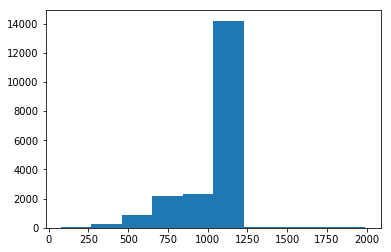

In [22]:
plt.hist(row_sz[row_sz<2000])

(array([ 288., 3006., 5454., 6607., 4771.,  138.,   18.,    1.,    2.,    4.]),
 array([  30. ,  184.5,  339. ,  493.5,  648. ,  802.5,  957. , 1111.5, 1266. , 1420.5, 1575. ]),
 <a list of 10 Patch objects>)

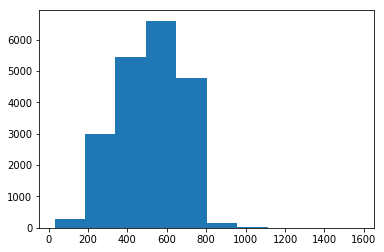

In [23]:
plt.hist(col_sz)

(array([  66.,  595., 2125., 2870., 4137., 5163., 4416.,  760.,  129.,   12.]),
 array([ 30. , 126.9, 223.8, 320.7, 417.6, 514.5, 611.4, 708.3, 805.2, 902.1, 999. ]),
 <a list of 10 Patch objects>)

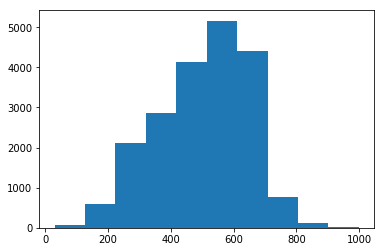

In [24]:
plt.hist(col_sz[col_sz<1000])

Looks like 75% of the data has a length between 1000 and 1200 pixels. Meanwhile there's a distribution of heights from 200 to 800 pixels.

In [27]:
len(data.trn_ds), len(data.test_ds)

(20289, 7960)

In [28]:
len(data.classes), data.classes[:5]

(5005, ['new_whale', 'w_0003639', 'w_0003c59', 'w_0027efa', 'w_00289b1'])

 ## Inital Model

In [31]:
def get_data(sz, bs): # sz: image size, bs: batch size
    tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=1.1)
    data = ImageClassifierData.from_csv(PATH, 'train', f'{PATH}train.csv', test_name='test',
                                       val_idxs=val_idxs, suffix='', tfms=tfms, bs=bs)
    
    # http://forums.fast.ai/t/how-to-train-on-the-full-dataset-using-imageclassifierdata-from-csv/7761/13
    # http://forums.fast.ai/t/how-to-train-on-the-full-dataset-using-imageclassifierdata-from-csv/7761/37
    return data if sz > 300 else data.resize(340, 'tmp') # Reading the jpgs and resizing is slow for big images, so resizing them all to 340 first saves time

### Precompute

In [32]:
data = get_data(sz, bs)

In [33]:
learn = ConvLearner.pretrained(arch, data, precompute=True)

100%|██████████| 138/138 [03:13<00:00,  1.08s/it]


In [34]:
learn.fit(1e-2, 5)

epoch      trn_loss   val_loss   accuracy                   
    0      5.966936   5.62474    0.382492  
    1      5.387898   5.427078   0.386632                   
    2      5.112792   5.266909   0.39097                    
    3      4.83662    5.152948   0.394125                   
    4      4.501909   5.058384   0.397871                   



[array([5.05838]), 0.39787066199049964]

### Augment

In [35]:
from sklearn import metrics

In [36]:
data = get_data(sz, bs)

In [37]:
learn = ConvLearner.pretrained(arch, data, precompute=True, ps=0.5)

In [38]:
learn.fit(1e-2, 2)

epoch      trn_loss   val_loss   accuracy                   
    0      5.927065   5.657636   0.382098  
    1      5.434787   5.466563   0.38545                    



[array([5.46656]), 0.3854495253037861]

In [39]:
learn.precompute = False

In [40]:
learn.fit(1e-2, 5, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                   
    0      5.329419   5.374768   0.389196  
    1      5.330996   5.319299   0.388604                   
    2      5.116787   5.266834   0.390379                   
    3      5.099875   5.216399   0.39235                    
    4      5.039721   5.178133   0.392153                   



[array([5.17813]), 0.39215299620495797]

In [41]:
learn.save('224_pre')

Given that simply guessing new_whale for every photo gives an accuaracy of 32.5

In [ ]:
learn.load('224_pre')

### Increase size

In [42]:
# Starting training on small images for a few epochs, then switching to bigger images, and continuing training is an amazingly effective way to avoid overfitting.

# http://forums.fast.ai/t/planet-classification-challenge/7824/96
# set_data doesn’t change the model at all. It just gives it new data to train with.
learn.set_data(get_data(299, bs)) 
learn.freeze()

In [ ]:
learn.summary()

In [43]:
learn.fit(1e-2, 3, cycle_len=1)

  2%|▏         | 7/350 [00:19<15:37,  2.73s/it, loss=5.08]

KeyboardInterrupt: 